# 1. Importing the data

Before the acutal clustering can take place, the data need to be imported and prepared. 
#### 1. The following columns will be dropped:
- junction_id: because it is a unique id, it wont be of any value for clustering
- junction_type: this is always the same value "traffic_light" 
- z: in the example scenarios, there are no z-values 
- connections: is a list of informations regarding connections that will be used later. it cannot be used for clustering
  since it is not numerical data
- intl_connections: same as connections

#### 2. The roundabout field will be converted from {true|false} to {0|1} 
#### 3. edge_types will be replaced
edge_types currently is a list of all types of edges connected to a junction. This needs to be converted into a set of 
numerical values. For this task a MultiLabelBinarizer is used. 

In [1]:
import pandas as pd
import numpy as np
import ast
#import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames
import copy

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer

columns=["junction_id","junction_type","x","y","z","isRoundabout","connections","avg_lane_speed","lane_speeds_std_deviation",
     "avg_lane_length","lane_length_standard_deviation","edge_types","edge_prioities","number_of_lanes"
     ,"intl_connections","intl_avg_lane_speed","intl_lane_speeds_std_deviation",
     "intl_avg_lane_length","intl_lane_length_standard_deviation","intl_edge_types","intl_edge_prioities","intl_number_of_lanes"]


def prepare_columns(df):
    df.columns=columns
    df= df.drop(df.columns[[0, 1, 4,6,14]], axis=1)
    
    fixed_types= df['edge_types'].map(lambda x: ast.literal_eval(x))
    df['isRoundabout']= df['isRoundabout'].astype(float)    
    result= mlb.transform(fixed_types)
    

    dfn= pd.DataFrame(result,columns=list(mlb.classes_))
    df=df.drop('edge_types',1)
    df=df.drop('intl_edge_types',1)
    return pd.concat([df,dfn],axis=1)



lust_file_name= "dataset-lust-tl.csv"
lust_raw_df= pd.read_csv(lust_file_name)

print "lust dataset loaded, {} rows, cols".format(lust_raw_df.shape)
cgn_file_name= "dataset-cgn-tl.csv"
cgn_raw_df= pd.read_csv(cgn_file_name)

print "cgn dataset loaded, {} rows".format(cgn_raw_df.shape)


cgn_raw_df.columns= copy.copy(columns)
lust_raw_df.columns= copy.copy(columns)


combined_raw_df=pd.concat([lust_raw_df,cgn_raw_df])
combined_raw_df.columns= copy.copy(columns)
print "combined dataset loaded, {} rows".format(combined_raw_df.shape)
mlb = MultiLabelBinarizer()
fixed_types= combined_raw_df['edge_types'].map(lambda x: ast.literal_eval(x))
mlb=mlb.fit(fixed_types)
#print list(mlb.classes_)

lust_dataset= prepare_columns(lust_raw_df)
print "lust dataset prepared, {} rows, cols".format(lust_dataset.shape)

cgn_dataset= prepare_columns(cgn_raw_df)
print "lust dataset prepared, {} rows, cols".format(cgn_dataset.shape)

combined_dataset= pd.concat([cgn_dataset,lust_dataset],axis=0)
print "lust dataset prepared, {} rows, cols".format(combined_dataset.shape)

lust dataset loaded, (202, 22) rows, cols
cgn dataset loaded, (1218, 22) rows
combined dataset loaded, (1420, 22) rows
lust dataset prepared, (202, 33) rows, cols
lust dataset prepared, (1218, 33) rows, cols
lust dataset prepared, (1420, 33) rows, cols


# 2. Dataset Analysis
It can clearly be seen that features are on very different scales. Feature Scaling must be applied as a next step to prepare for clustering the data. If the data were used without feature scaling, the x/y values of the junctions position on the map would probably have the biggest impact on the results. This is not really desirable.

In [2]:
import seaborn as sns

display(combined_dataset.describe())


,x,y,isRoundabout,avg_lane_speed,lane_speeds_std_deviation,avg_lane_length,lane_length_standard_deviation,edge_prioities,number_of_lanes,intl_avg_lane_speed,...,highway.primary|railway.tram,highway.residential,highway.secondary,highway.secondary_link,highway.tertiary,highway.tertiary_link,highway.tertiary|railway.tram,highway.trunk,highway.trunk_link,highway.unclassified
count,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,...,1420.000000,1420.00000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000
mean,13271.370824,13850.000155,0.041549,13.815991,0.748726,139.582831,68.643406,6.867463,4.723239,2.070447,...,0.000704,0.45493,0.440845,0.033803,0.266197,0.017606,0.005634,0.005634,0.011268,0.107042
std,5996.187461,6883.137889,0.199627,2.006128,1.470907,142.816742,101.624359,1.515603,2.180093,5.099828,...,0.026537,0.49814,0.496663,0.180785,0.442124,0.131559,0.074873,0.074873,0.105586,0.309276
min,1328.740000,601.490000,0.000000,2.780000,0.000000,6.450000,0.000000,3.000000,1.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9029.620000,8624.992500,0.000000,13.890000,0.000000,54.331071,12.241999,6.000000,3.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13076.180000,13815.720000,0.000000,13.890000,0.000000,102.668333,38.379295,6.750000,4.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16728.860000,16925.877500,0.000000,13.890000,1.382295,169.387875,81.535628,8.000000,6.000000,0.000000,...,0.000000,1.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,31012.170000,33380.670000,1.000000,48.610000,34.720000,1386.280000,1537.645770,12.000000,16.000000,18.808182,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


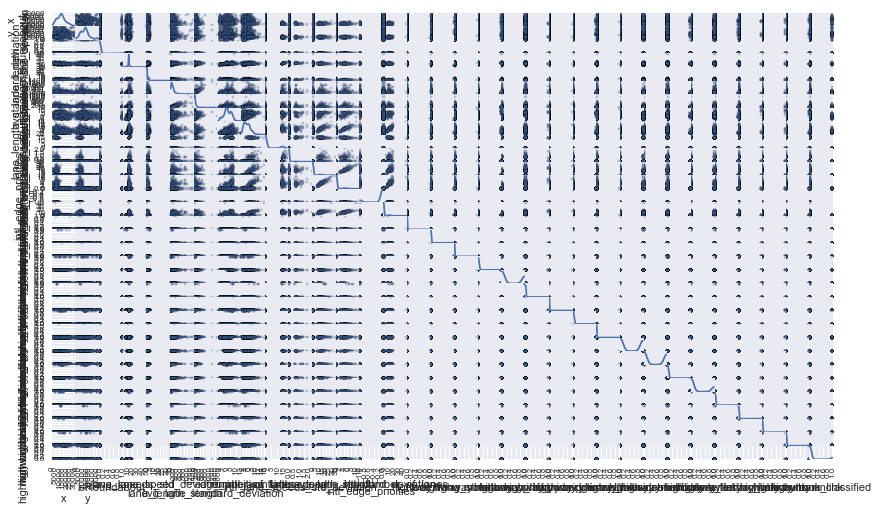

In [3]:
pd.scatter_matrix(combined_dataset, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

# 3. Feature Scaling
As I've learned in the course and in some further reading [1] feature scaling is necessary for this dataset.



[1] http://stats.stackexchange.com/questions/19216/variables-are-often-adjusted-e-g-standardised-before-making-a-model-when-is

The results of both, the RobustScaler and the MaxAbsScaler look quite promising:
The clusters look very well separated with high silhouette scores and the PCA components seem to make sense. 
This is why, both scaling algorithms will be used. Later it is still possible to evaluate them using the performance metrics of the simulation. 



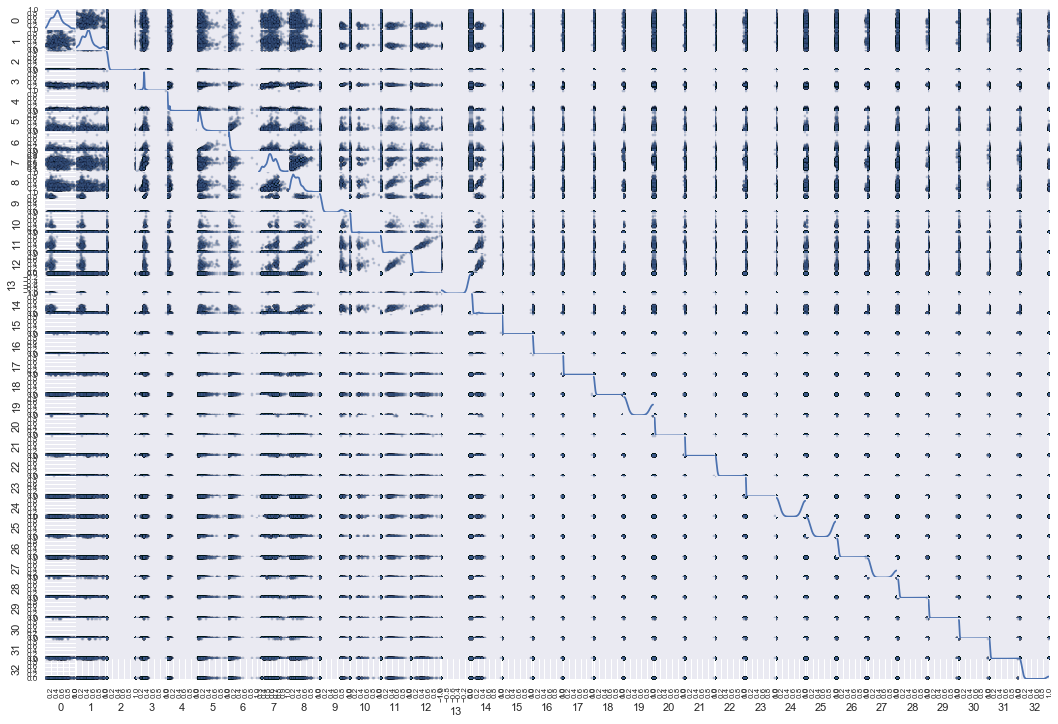

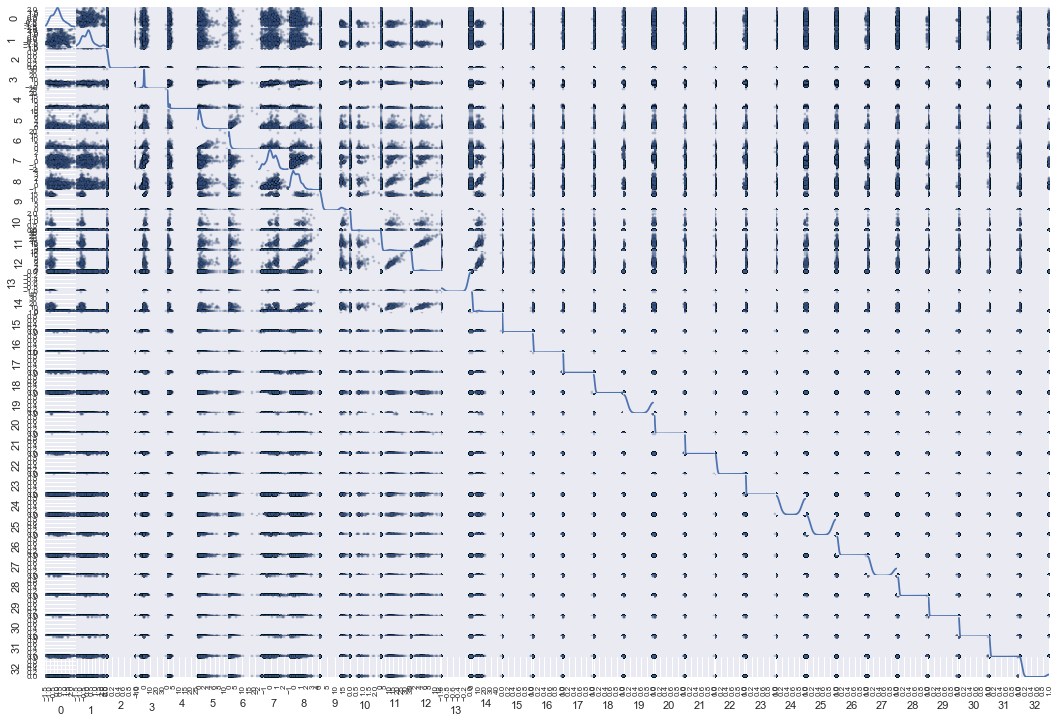

In [4]:

from sklearn import preprocessing
def scale_dataset_robust(data):
    min_max_scaler = preprocessing.RobustScaler()
    minmax = min_max_scaler.fit_transform(data)
    return pd.DataFrame(minmax)

def scale_dataset(data):   
    scaler= preprocessing.MaxAbsScaler()
    result = scaler.fit_transform(data)
    return pd.DataFrame(result)

scaled_lust_dataset=scale_dataset(lust_dataset)
scaled_cgn_dataset=scale_dataset(cgn_dataset)
scaled_combined_dataset=scale_dataset(combined_dataset)

scaled_lust_dataset_robust=scale_dataset_robust(lust_dataset)
scaled_cgn_dataset_robust=scale_dataset_robust(cgn_dataset)
scaled_combined_dataset_robust=scale_dataset_robust(combined_dataset)


# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(scaled_combined_dataset, alpha = 0.3, figsize = (18,12), diagonal = 'kde');
pd.scatter_matrix(scaled_combined_dataset_robust, alpha = 0.3, figsize = (18,12), diagonal = 'kde');

# 4. Dimensionality Reduction
Two different algorithms for dimensionality reduction will be applied. PCA and KernelPCA.
Because the explained variances for the 4th dimension appear to be of some importance, both 3d and 4d datasets will be computed and evaluated further.
## 4.1 KPCA
For KPCA the standard configuration and an rbf Kernel have been proven to give the best results. 
The fourth dimension (see Last Chapter) does not play as much as a role as I first asumed and is therefore not computed for KPCA. Furthermore I later found that the results of KPCA are not significantly different from PCA and therefore used only the PCA results subsequently.


In [5]:
from sklearn.decomposition import KernelPCA

def apply_kpca(dataset):
    kpca= KernelPCA(n_components=3,kernel='rbf', random_state=87658)
    results= kpca.fit(dataset)
    results= kpca.transform(dataset)
    return pd.DataFrame(results, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])

kpca_reduced_scaled_cgn_dataset = apply_kpca(scaled_cgn_dataset)
kpca_reduced_scaled_lust_dataset = apply_kpca(scaled_lust_dataset)
kpca_reduced_scaled_combined_dataset = apply_kpca(scaled_combined_dataset)

## 4.2 Analysis of PCA components
### 4.2.1. Analysis of PCA Components for the MaxABSScaler


Analyzing LUST Dataset:
Dimension 1    0.2777
Dimension 2    0.5234
Dimension 3    0.7251
Dimension 4    0.7928
Name: Explained Variance, dtype: float64


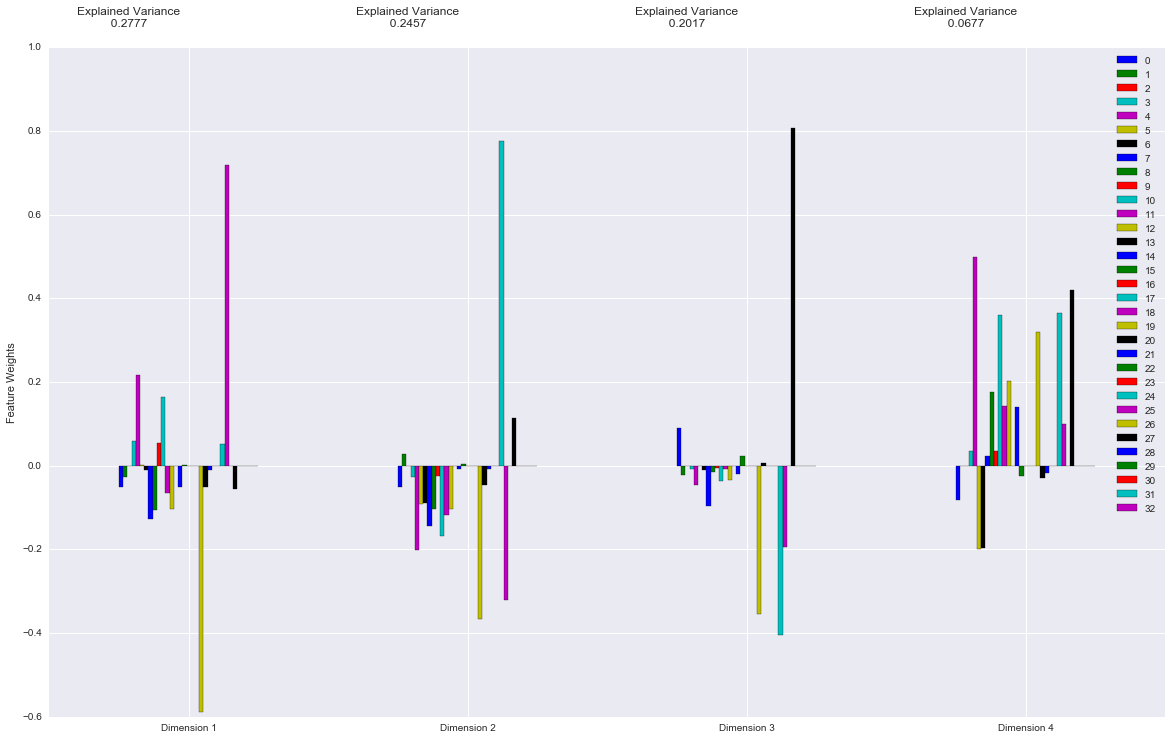

In [6]:
from sklearn.decomposition import PCA
import renders as rs

def pca_analyse(dataset):  
    pca = PCA(n_components=4).fit(dataset)
    pca_results = rs.pca_results(dataset, pca)
    print pca_results['Explained Variance'].cumsum()
print ("Analyzing LUST Dataset:")

pca_analyse (scaled_lust_dataset)

Dimension 1    0.2367
Dimension 2    0.4396
Dimension 3    0.6125
Dimension 4    0.7171
Name: Explained Variance, dtype: float64


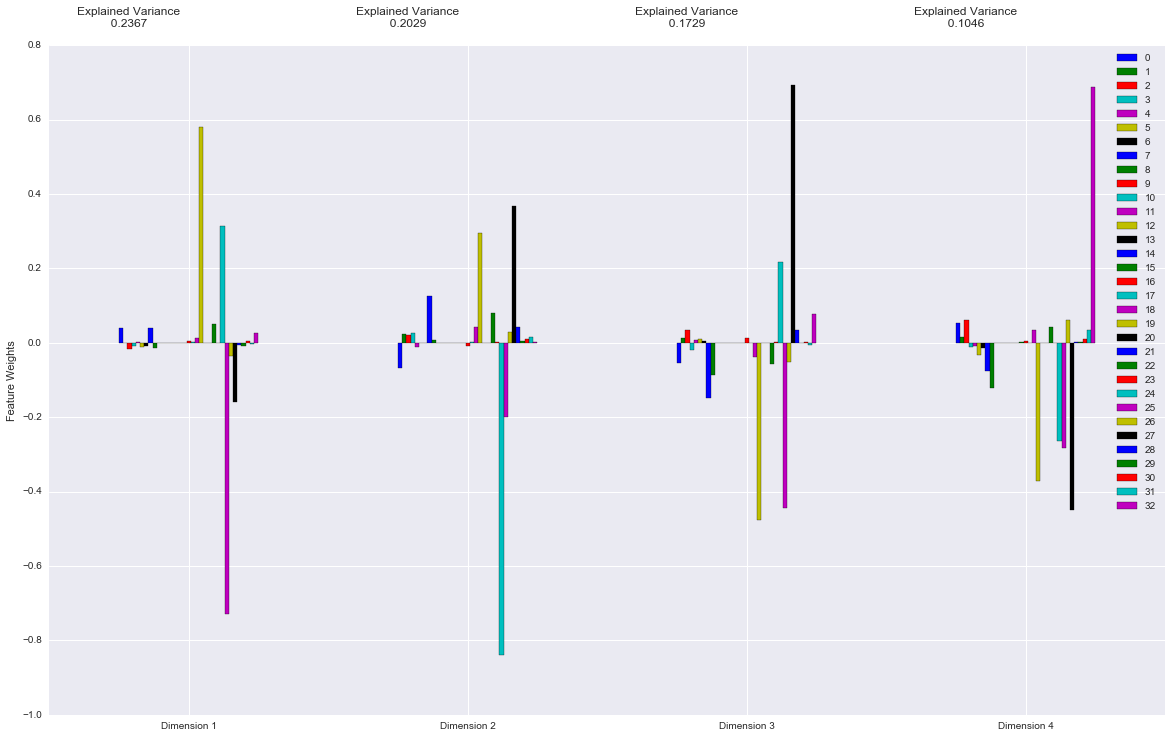

In [7]:
pca_analyse (scaled_cgn_dataset)

Dimension 1    0.2280
Dimension 2    0.4081
Dimension 3    0.5703
Dimension 4    0.7059
Name: Explained Variance, dtype: float64


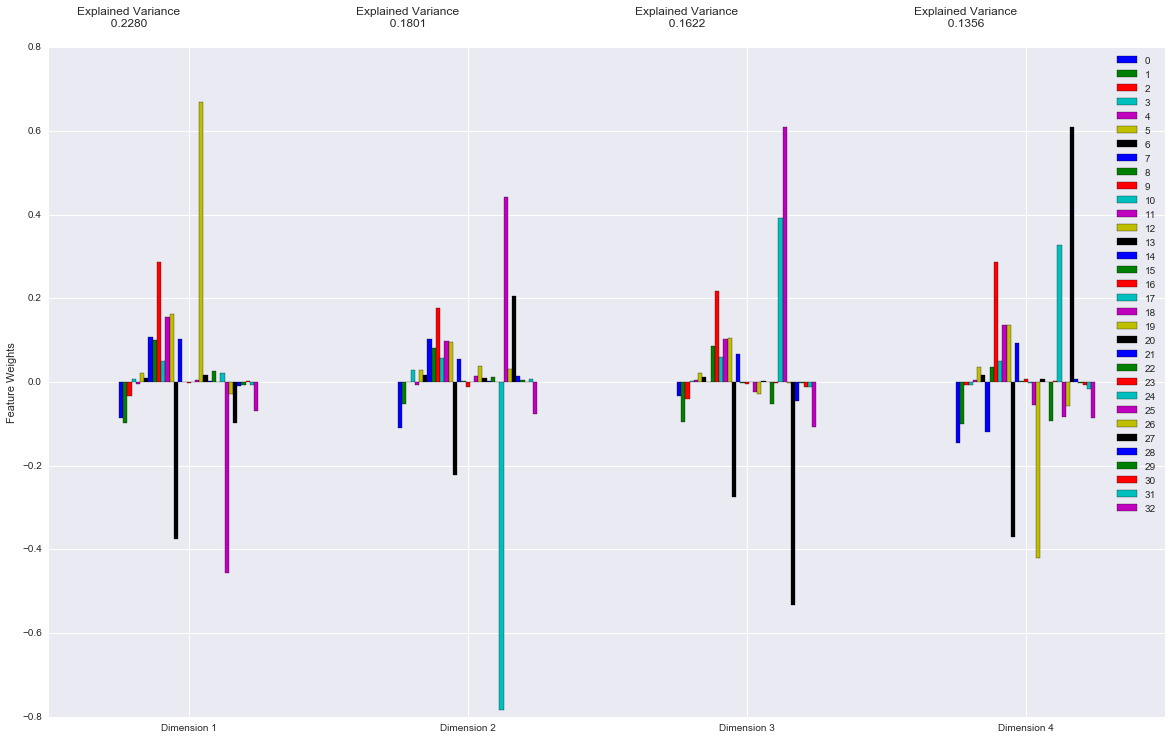

In [8]:
pca_analyse (scaled_combined_dataset)

#### 4.2.3 Analysis of PCA with RobustScaler

Dimension 1    0.3816
Dimension 2    0.6166
Dimension 3    0.7089
Dimension 4    0.7730
Name: Explained Variance, dtype: float64


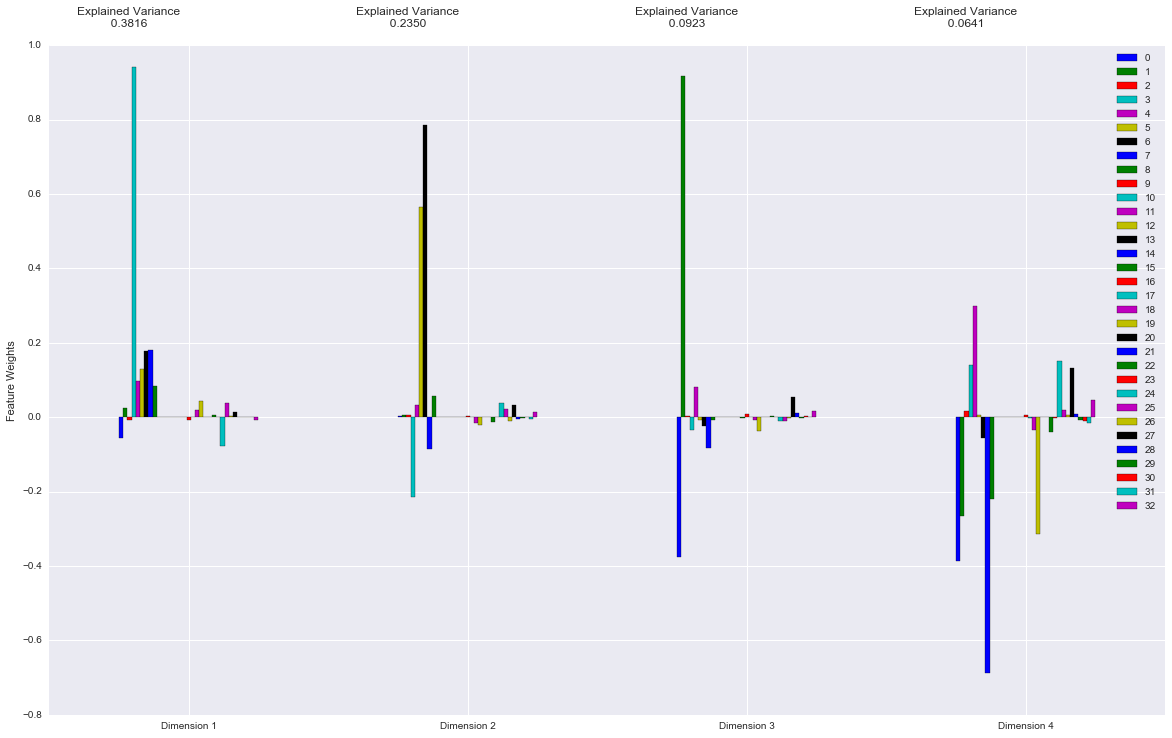

In [9]:
pca_analyse (scaled_cgn_dataset_robust)

Dimension 1    0.2870
Dimension 2    0.5145
Dimension 3    0.6931
Dimension 4    0.7771
Name: Explained Variance, dtype: float64


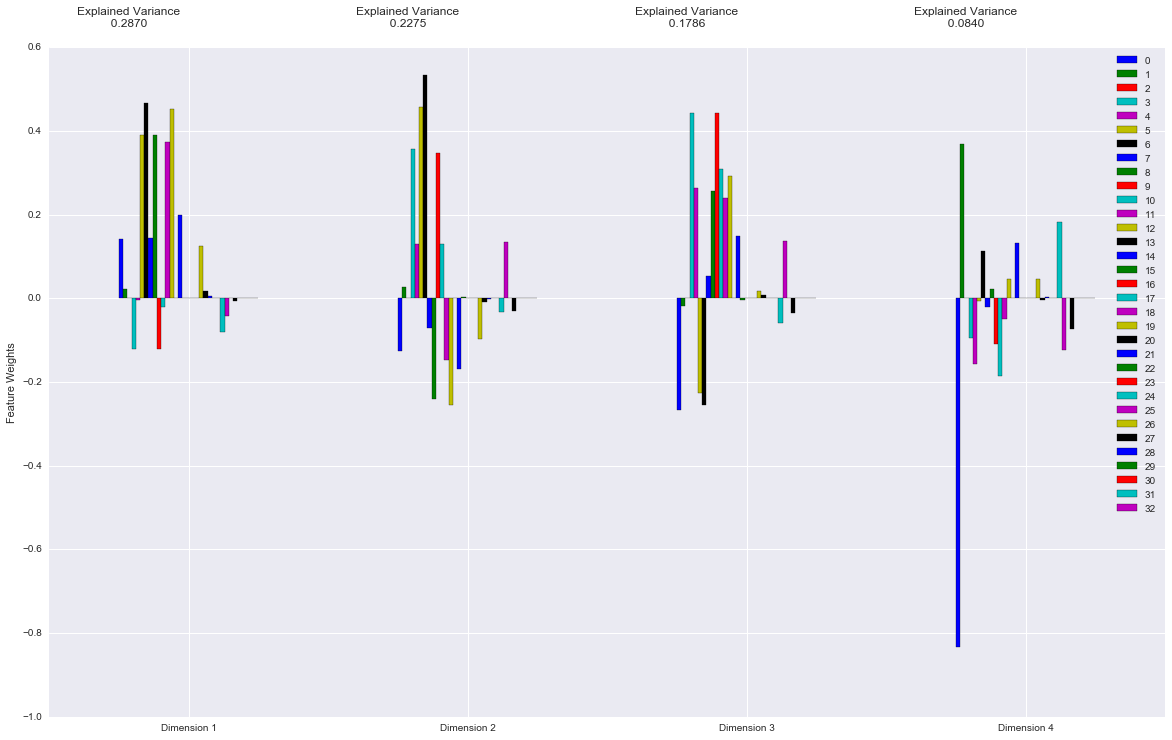

In [10]:
pca_analyse (scaled_lust_dataset_robust)

Dimension 1    0.8213
Dimension 2    0.8719
Dimension 3    0.9081
Dimension 4    0.9348
Name: Explained Variance, dtype: float64


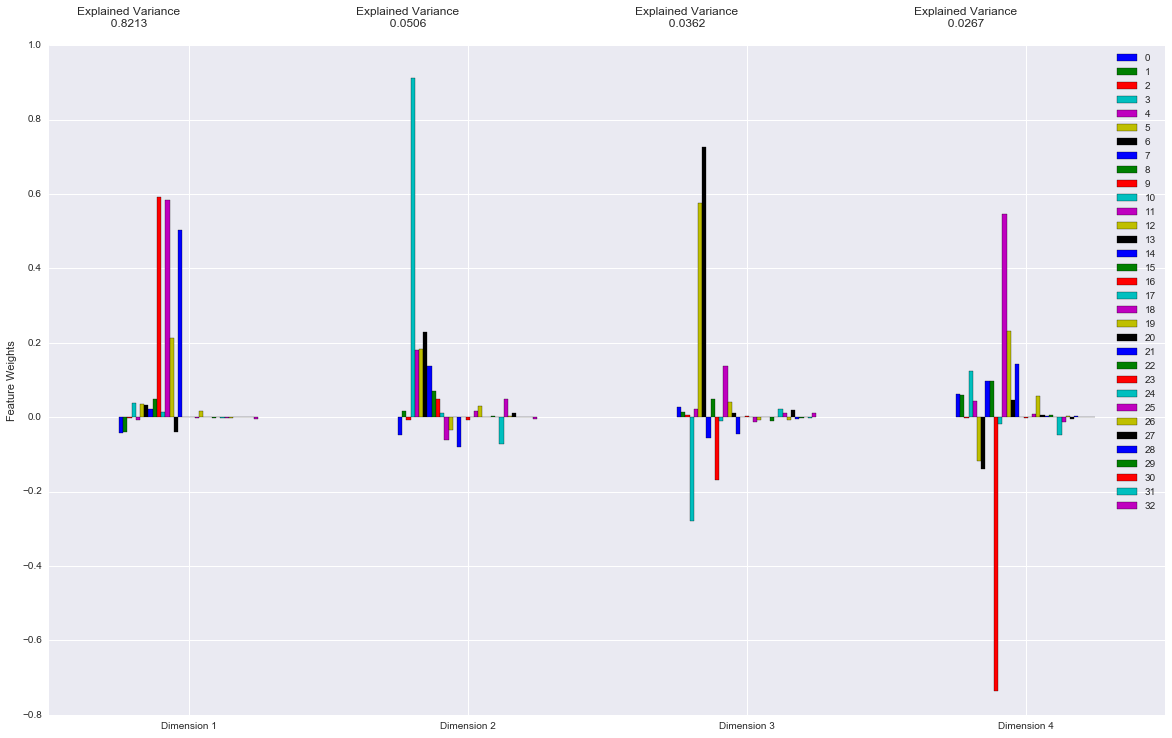

In [11]:
pca_analyse (scaled_combined_dataset_robust)

#### 4.2.4 Apply PCA for 3 and 4 dimensions on robust and abs scaled datasets


In [12]:
# Fit PCA to the good data using three dimensions, for both scalers
cmb_pca =  PCA(n_components=3).fit(scaled_combined_dataset)
cgn_pca =  PCA(n_components=3).fit(scaled_cgn_dataset)
lst_pca =  PCA(n_components=3).fit(scaled_lust_dataset)
cmb_pca_robust = PCA(n_components=3).fit(scaled_combined_dataset_robust)
cgn_pca_robust = PCA(n_components=3).fit(scaled_cgn_dataset_robust)
lst_pca_robust = PCA(n_components=3).fit(scaled_lust_dataset_robust)

# Apply a PCA transformation the good data
cmb_reduced_data = cmb_pca.transform(scaled_combined_dataset)
cgn_reduced_data = cgn_pca.transform(scaled_cgn_dataset)
lst_reduced_data = lst_pca.transform(scaled_lust_dataset)

cmb_reduced_data_robust = cmb_pca_robust.transform(scaled_combined_dataset_robust)
cgn_reduced_data_robust = cgn_pca_robust.transform(scaled_cgn_dataset_robust)
lst_reduced_data_robust = lst_pca_robust.transform(scaled_lust_dataset_robust)


# Create DataFrames 
reduced_scaled_combined_dataset = pd.DataFrame(cmb_reduced_data, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])
reduced_scaled_cgn_dataset = pd.DataFrame(cgn_reduced_data, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])
reduced_scaled_lust_dataset = pd.DataFrame(lst_reduced_data, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])

reduced_scaled_combined_dataset_robust = pd.DataFrame(cmb_reduced_data_robust, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])
reduced_scaled_cgn_dataset_robust = pd.DataFrame(cgn_reduced_data_robust, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])
reduced_scaled_lust_dataset_robust = pd.DataFrame(lst_reduced_data_robust, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])

In [13]:
# Fit PCA to the good data using 4 dimensions, using both scalers
cmb_pca4 =  PCA(n_components=4).fit(scaled_combined_dataset)
cgn_pca4 =  PCA(n_components=4).fit(scaled_cgn_dataset)
lst_pca4 =  PCA(n_components=4).fit(scaled_lust_dataset)

cmb_pca_robust4 = PCA(n_components=4).fit(scaled_combined_dataset_robust)
cgn_pca_robust4 = PCA(n_components=4).fit(scaled_cgn_dataset_robust)
lst_pca_robust4 = PCA(n_components=4).fit(scaled_lust_dataset_robust)

# Apply a PCA transformation the good data using 4 dimensions, using both scalers
cmb_reduced_data4 = cmb_pca4.transform(scaled_combined_dataset)
cgn_reduced_data4 = cgn_pca4.transform(scaled_cgn_dataset)
lst_reduced_data4 = lst_pca4.transform(scaled_lust_dataset)

cmb_reduced_data_robust4 = cmb_pca_robust4.transform(scaled_combined_dataset_robust)
cgn_reduced_data_robust4 = cgn_pca_robust4.transform(scaled_cgn_dataset_robust)
lst_reduced_data_robust4 = lst_pca_robust4.transform(scaled_lust_dataset_robust)

# Create DataFrames for the reduced data
reduced_scaled_combined_dataset4 = pd.DataFrame(cmb_reduced_data4, columns = ['Dimension 1', 'Dimension 2','Dimension 3','Dimension 4'])
reduced_scaled_cgn_dataset4 = pd.DataFrame(cgn_reduced_data4, columns = ['Dimension 1', 'Dimension 2','Dimension 3','Dimension 4'])
reduced_scaled_lust_dataset4 = pd.DataFrame(lst_reduced_data4, columns = ['Dimension 1', 'Dimension 2','Dimension 3','Dimension 4'])

reduced_scaled_combined_dataset_robust4 = pd.DataFrame(cmb_reduced_data_robust4, columns = ['Dimension 1', 'Dimension 2','Dimension 3','Dimension 4'])
reduced_scaled_cgn_dataset_robust4 = pd.DataFrame(cgn_reduced_data_robust4, columns = ['Dimension 1', 'Dimension 2','Dimension 3','Dimension 4'])
reduced_scaled_lust_dataset_robust4 = pd.DataFrame(lst_reduced_data_robust4, columns = ['Dimension 1', 'Dimension 2','Dimension 3','Dimension 4'])

# 5 Apply Clustering

Clusters will be chose by their silhouette_score. The clustering result with the highest score will be chosen for the evaluation in later chapters. 

In [ ]:
from sklearn import mixture
from sklearn.metrics import silhouette_score

def apply_clustering(reduced_data):
    covar_types = ['spherical', 'diag', 'tied', 'full']
    covar_type = covar_types[3]
    scores=[]
    best_preds=None
    best_centers=None
    best_score=0
    for n in range(2,40):    
        clusterer = mixture.GaussianMixture (n_components= n, covariance_type=covar_type, max_iter=250, random_state= 512*n).fit(reduced_data)
        preds = clusterer.predict(reduced_data)        
        centers = clusterer.means_
        score = silhouette_score(reduced_data, preds, metric='euclidean')
        if score>best_score:
            best_score=score
            best_preds=preds
            best_centers=centers
            #print "\tnew best cluster count {}".format(n)

        scores.append(score)        
    return (best_preds,best_centers, scores)
print "3d clustering for cgn..."
reduced_scaled_cgn_dataset_clusters= apply_clustering(reduced_scaled_cgn_dataset)
print "3d clustering for lust..."
reduced_scaled_lust_dataset_clusters= apply_clustering(reduced_scaled_lust_dataset)
print "3d clustering for both..."
reduced_scaled_combined_dataset_clusters= apply_clustering(reduced_scaled_combined_dataset)

max_table= pd.DataFrame([[np.max(reduced_scaled_cgn_dataset_clusters[2]),np.max(reduced_scaled_lust_dataset_clusters[2]) ,
             np.max(reduced_scaled_combined_dataset_clusters[2])]],columns=['cgn_max', 'lust_max','combined_max'])
display(max_table)

results_table= pd.DataFrame()
results_table["cgn_scores"]=reduced_scaled_cgn_dataset_clusters[2]
results_table["lust_scores"]=reduced_scaled_lust_dataset_clusters[2]
results_table["combined_scores"]=reduced_scaled_combined_dataset_clusters[2]
results_table.index= np.arange(2, len(results_table)+2)
display(results_table)

In [ ]:
print "3d clustering for cgn(robust scaler)..."
reduced_scaled_cgn_dataset_clusters_robust= apply_clustering(reduced_scaled_cgn_dataset_robust)
print "3d clustering for lust(robust scaler)..."
reduced_scaled_lust_dataset_clusters_robust= apply_clustering(reduced_scaled_lust_dataset_robust)
print "3d clustering for both(robust scaler)..."
reduced_scaled_combined_dataset_clusters_robust= apply_clustering(reduced_scaled_combined_dataset_robust)

max_table= pd.DataFrame([[np.max(reduced_scaled_cgn_dataset_clusters_robust[2]),np.max(reduced_scaled_lust_dataset_clusters_robust[2]) ,
             np.max(reduced_scaled_combined_dataset_clusters_robust[2])]],columns=['cgn_max', 'lust_max','combined_max'])
display(max_table)

results_table= pd.DataFrame()
results_table["cgn_scores"]=reduced_scaled_cgn_dataset_clusters_robust[2]
results_table["lust_scores"]=reduced_scaled_lust_dataset_clusters_robust[2]
results_table["combined_scores"]=reduced_scaled_combined_dataset_clusters_robust[2]
results_table.index= np.arange(2, len(results_table)+2)
display(results_table)

In [ ]:
print "4d clustering for cgn..."
reduced_scaled_cgn_dataset_clusters4= apply_clustering(reduced_scaled_cgn_dataset4)
print "4d clustering for lust..."
reduced_scaled_lust_dataset_clusters4= apply_clustering(reduced_scaled_lust_dataset4)
print "4d clustering for both..."
reduced_scaled_combined_dataset_clusters4= apply_clustering(reduced_scaled_combined_dataset4)

max_table= pd.DataFrame([[np.max(reduced_scaled_cgn_dataset_clusters4[2]),np.max(reduced_scaled_lust_dataset_clusters4[2]) ,
             np.max(reduced_scaled_combined_dataset_clusters4[2])]],columns=['cgn_max', 'lust_max','combined_max'])
display(max_table)

results_table= pd.DataFrame()
results_table["cgn_scores"]=reduced_scaled_cgn_dataset_clusters4[2]
results_table["lust_scores"]=reduced_scaled_lust_dataset_clusters4[2]
results_table["combined_scores"]=reduced_scaled_combined_dataset_clusters4[2]
results_table.index= np.arange(2, len(results_table)+2)
display(results_table)

In [ ]:
print "4d clustering for cgn(robust scaler)..."
reduced_scaled_cgn_dataset_clusters_robust4= apply_clustering(reduced_scaled_cgn_dataset_robust4)
print "4d clustering for lust(robust scaler)..."
reduced_scaled_lust_dataset_clusters_robust4= apply_clustering(reduced_scaled_lust_dataset_robust4)
print "4d clustering for both(robust scaler)..."
reduced_scaled_combined_dataset_clusters_robust4= apply_clustering(reduced_scaled_combined_dataset_robust4)

max_table= pd.DataFrame([[np.max(reduced_scaled_cgn_dataset_clusters_robust4[2]),np.max(reduced_scaled_lust_dataset_clusters_robust4[2]) ,
             np.max(reduced_scaled_combined_dataset_clusters_robust4[2])]],columns=['cgn_max', 'lust_max','combined_max'])
display(max_table)

results_table= pd.DataFrame()
results_table["cgn_scores"]=reduced_scaled_cgn_dataset_clusters_robust4[2]
results_table["lust_scores"]=reduced_scaled_lust_dataset_clusters_robust4[2]
results_table["combined_scores"]=reduced_scaled_combined_dataset_clusters_robust4[2]
results_table.index= np.arange(2, len(results_table)+2)
display(results_table)

In [ ]:
from sklearn import cluster

def apply_clustering_on_kpcasets(reduced_data):
    covar_types = ['spherical', 'diag', 'tied', 'full']
    covar_type = covar_types[3]
    scores=[]
    best_preds=None
    best_centers=None
    best_score=0
    
    for n in range(2,40):    
        clusterer = cluster.KMeans(n_clusters= n, max_iter=300, random_state= 512*n).fit(reduced_data)
        preds = clusterer.predict(reduced_data)        
        centers = clusterer.cluster_centers_
        
        try:
            score = silhouette_score(reduced_data, preds, metric='euclidean')
        except ValueError:
            scores.append(0)
            continue
        if score>best_score:
            best_score=score
            best_preds=preds
            best_centers=centers
            #print "\tnew best cluster count {}".format(n)

        scores.append(score)        
    return (best_preds,best_centers, scores)

kpca_reduced_scaled_cgn_dataset_clusters= apply_clustering_on_kpcasets(kpca_reduced_scaled_cgn_dataset)
kpca_reduced_scaled_lust_dataset_clusters= apply_clustering_on_kpcasets(kpca_reduced_scaled_lust_dataset)
kpca_reduced_scaled_combined_dataset_clusters= apply_clustering_on_kpcasets(kpca_reduced_scaled_combined_dataset)

max_table= pd.DataFrame([[np.max(kpca_reduced_scaled_cgn_dataset_clusters[2]),np.max(kpca_reduced_scaled_lust_dataset_clusters[2]) ,
             np.max(kpca_reduced_scaled_combined_dataset_clusters[2])]],columns=['cgn_max', 'lust_max','combined_max'])
display(max_table)

results_table=pd.DataFrame()
results_table["cgn_scores"]=kpca_reduced_scaled_cgn_dataset_clusters[2]
results_table["lust_scores"]=kpca_reduced_scaled_lust_dataset_clusters[2]
results_table["combined_scores"]=kpca_reduced_scaled_combined_dataset_clusters[2]
results_table.index= np.arange(2, len(results_table)+2)
display(results_table)

# 6  Analysis of Results
## 6.1 Graphical Analysis

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import colormap as cmap

def show_3d_plot(reduced_data, centers, preds):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    n = 100
    for i,series in enumerate(reduced_data.iterrows()):
        p=preds[i]
        xs = series[1].get(0)
        ys = series[1].get(1)
        zs = series[1].get(2)

        ax.scatter(xs, ys, zs, c=cmap.colors[p])

    for i, series in enumerate(centers):    
        ax.scatter(series[0],series[1],series[2], c = 'white', edgecolors = 'black', \
        alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(series[0],series[1],series[2], marker='$%d$'%(i), alpha = 1, s=100);

    ax.set_xlabel(reduced_data.columns[0])
    ax.set_ylabel(reduced_data.columns[1])
    ax.set_zlabel(reduced_data.columns[2])

    plt.show()
    print "MAxMin Scaler PCA 3 Dimension Clusters"
    show_3d_plot(reduced_scaled_cgn_dataset,reduced_scaled_cgn_dataset_clusters[1],reduced_scaled_cgn_dataset_clusters[0])

In [ ]:
print "Cologne- Robust Scaler PCA 3 Dimension Clusters"
show_3d_plot(reduced_scaled_cgn_dataset_robust,reduced_scaled_cgn_dataset_clusters_robust[1],reduced_scaled_cgn_dataset_clusters_robust[0])

In [ ]:
show_3d_plot(reduced_scaled_lust_dataset,reduced_scaled_lust_dataset_clusters[1],reduced_scaled_lust_dataset_clusters[0])

In [ ]:
print "Lust- Robust Scaler PCA 3 Dimension Clusters"
show_3d_plot(reduced_scaled_lust_dataset_robust,reduced_scaled_lust_dataset_clusters_robust[1],reduced_scaled_lust_dataset_clusters_robust[0])

In [ ]:
# Display the results of the clustering from implementation

show_3d_plot(reduced_scaled_combined_dataset,reduced_scaled_combined_dataset_clusters[1],reduced_scaled_combined_dataset_clusters[0])


In [ ]:
print "Combined- Robust Scaler PCA 3 Dimension Clusters"
show_3d_plot(reduced_scaled_combined_dataset_robust,reduced_scaled_combined_dataset_clusters_robust[1],reduced_scaled_combined_dataset_clusters_robust[0])

In [ ]:
def show_3d_plot_centers(centers, m, centers1, m1,centers2, m2):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    n = 100

    for i, series in enumerate(centers):    
        ax.scatter(series[0],series[1],series[2], c = '#00ff00',  \
        marker = m, s=200);
        
    for i, series in enumerate(centers1):    
        ax.scatter(series[0],series[1],series[2], c = '#ff0000',  \
        marker = m1, s=200);
    
    for i, series in enumerate(centers2):    
        ax.scatter(series[0],series[1],series[2], c = '#0000ff',  \
        marker = m2, s=200);
    

    #ax.set_xlabel(reduced_data.columns[0])
    #ax.set_ylabel(reduced_data.columns[1])
    #ax.set_zlabel(reduced_data.columns[2])

    plt.show()
show_3d_plot_centers(reduced_scaled_cgn_dataset_clusters[1],'o',reduced_scaled_lust_dataset_clusters[1],'^',reduced_scaled_combined_dataset_clusters[1],'<')

print "cgn centers:{}".format(len(reduced_scaled_cgn_dataset_clusters[1]))
print "lust centers:{}".format(len(reduced_scaled_lust_dataset_clusters[1]))
print "combined centers:{}".format(len(reduced_scaled_combined_dataset_clusters[1]))


In [ ]:
print ("kpca cgn")
show_3d_plot(kpca_reduced_scaled_cgn_dataset,kpca_reduced_scaled_cgn_dataset_clusters[1],kpca_reduced_scaled_cgn_dataset_clusters[0])


In [ ]:
print ("kpca lust")
show_3d_plot(kpca_reduced_scaled_lust_dataset,kpca_reduced_scaled_lust_dataset_clusters[1],kpca_reduced_scaled_lust_dataset_clusters[0])


In [ ]:
print ("kpca combined")
show_3d_plot(kpca_reduced_scaled_combined_dataset,kpca_reduced_scaled_combined_dataset_clusters[1],kpca_reduced_scaled_combined_dataset_clusters[0])

In [ ]:
show_3d_plot_centers(reduced_scaled_cgn_dataset_clusters[1],'o',kpca_reduced_scaled_cgn_dataset_clusters[1],'^',kpca_reduced_scaled_combined_dataset_clusters[1],'<')

print "cgn centers:{}".format(len(kpca_reduced_scaled_cgn_dataset_clusters[1]))
print "lust centers:{}".format(len(kpca_reduced_scaled_lust_dataset_clusters[1]))
print "combined centers:{}".format(len(kpca_reduced_scaled_combined_dataset_clusters[1]))


## 6.1 Analysis of Cluster similarity
To compare the results of the different Cluster analyses (scalers, dimensions...),
The following to code blocks compute a mapping between the found clusters.
This way the similarity of the two different clustering results can be seen.

To visualize this, for each datapoint in a cluster it is analyzed, in 
how many different clusters of the other result it appears.

For a perfect similarity every point of Cluster A should be in some Cluster B
of the other clustering result. 

#### Comparison of Pca and Kpca, with 3 dimensions 

In [ ]:
#data, centers, preds


def compare_clusters(dataset, clusters, clusters2):
    res={}
    for i, p in enumerate(dataset.iterrows()):
        cluster= clusters[i]    

        if (not cluster in res):
            res[cluster]={}
        other_cluster=clusters2[i]
        if (not other_cluster in res[cluster]):
            res[cluster][other_cluster]=0
        res[cluster][other_cluster]+=1
    return res



res=compare_clusters(reduced_scaled_cgn_dataset, kpca_reduced_scaled_cgn_dataset_clusters[0],reduced_scaled_cgn_dataset_clusters[0])
print "cgn_kpca #clusters:{}".format(len(kpca_reduced_scaled_cgn_dataset_clusters[1]))
print "cgn_pca #clusters:{}".format(len(reduced_scaled_cgn_dataset_clusters[1]))
print

print  "kpca_cluster --> [pca_cluster1: #points, pca_cluster2: #points....]"
for key, value in res.iteritems():
        print "{} --> {}".format(key, value)
    


In [ ]:
#data, centers, preds
print "comparing combined dataset clusters of kpca and pca"

res=compare_clusters(reduced_scaled_combined_dataset, kpca_reduced_scaled_combined_dataset_clusters[0],reduced_scaled_combined_dataset_clusters[0])
print "combined_kpca #clusters:{}".format(len(kpca_reduced_scaled_combined_dataset_clusters[1]))
print "combined_pca #clusters:{}".format(len(reduced_scaled_combined_dataset_clusters[1]))
print "kpca_cluster --> [pca_cluster1: #points, pca_cluster2: #points....]"
for key, value in res.iteritems():
        print "{} --> {}".format(key, value)
    


#### Results
The analysis shows that both algorithms kpca and pca, basically find the same clusters for the MaxABS Scaler.
Therefore it does not matter which algorithm to choose. 

#### Comparison of PCA based clustering results with 3 dimensions and PCA based clustering with 4 dimensions
For an additional examination of clusters based of a PCA reduced dataset with 4 dimensions the following test was run.
The conclusion is that no additional value is achieved using 4 dimensions since the identified clusters are basically all the same. The only exception being that PCA-4 found an additional cluster.

In [ ]:
#data, centers, preds
print "comparing combined dataset clusters of kpca and pca"

res=compare_clusters(reduced_scaled_combined_dataset4, reduced_scaled_combined_dataset_clusters[0],reduced_scaled_combined_dataset_clusters4[0])
print "combined_pca 4 dimensions #clusters:{}".format(len(reduced_scaled_combined_dataset_clusters4[1]))
print "combined_pca #clusters:{}".format(len(reduced_scaled_combined_dataset_clusters[1]))

print "pca_cluster3 --> [pca_cluster4_1: #points, pca_cluster4_2: #points....]"
for key, value in res.iteritems():
        print "{} --> {}".format(key, value)
    

#### Comparison of PCA based clustering results with 3 dimensions with different feature scaling

In [ ]:


res=compare_clusters(reduced_scaled_combined_dataset, reduced_scaled_combined_dataset_clusters_robust[0],reduced_scaled_combined_dataset_clusters[0])
print "combined_pca dimensions #clusters:{}".format(len(reduced_scaled_combined_dataset_clusters_robust[1]))
print "combined_pca #clusters:{}".format(len(reduced_scaled_combined_dataset_clusters[1]))

print "maxabs_cluster --> [cluster_robust_1: #points, cluster_robust_2: #points....]"
for key, value in res.iteritems():
        print "{} --> {}".format(key, value)
    

# 6.2 Conclusion of Analysis
The different scaling algorithms have a huge impact on the resulting clusters. This is why I decided to use PCA 3-Components results. The MaxABS based clusters and the RobustScaler based clusters for the following examinations. 
The best clustering method can easily be chosen measuring their respective performance using the defined metrics after running the live simulation.

# 7 Data Export
Finally append the clustering information to the dataset and write it back to a CSV file. 

In [ ]:

lust_raw_df= pd.read_csv(lust_file_name)
cgn_raw_df= pd.read_csv(cgn_file_name)
cgn_raw_df.columns= copy.copy(columns)
lust_raw_df.columns= copy.copy(columns)

clusters_maxabs_cgn= reduced_scaled_cgn_dataset_clusters[0]
clusters_robust_cgn= reduced_scaled_cgn_dataset_clusters_robust[0]

clusters_maxabs_lust= reduced_scaled_lust_dataset_clusters[0]
clusters_robust_lust= reduced_scaled_lust_dataset_clusters_robust[0]

cgn_raw_df['clusters_maxabs_3dimensions']=clusters_maxabs_cgn
cgn_raw_df['clusters_robust_3dimensions']=clusters_robust_cgn 

lust_raw_df['clusters_maxabs_3dimensions']=clusters_maxabs_lust
lust_raw_df['clusters_robust_3dimensions']=clusters_robust_lust 

cgn_raw_df.to_csv("dataset-cgn-tl-clusters.csv")
lust_raw_df.to_csv("dataset-lust-tl-clusters.csv")
